In [36]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import MySQLdb
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
conn = MySQLdb.connect(host="localhost", user="root", passwd="", db="iot")
cursor = conn.cursor()
cursor.execute('select time, source, destination, protocol, type, size from ip limit 250');

rows = cursor.fetchall()

In [54]:
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
df.rename(columns={0: 'Time', 1: 'Source', 2: 'Destination', 3: 'Protocol', 4:'Type', 5:'Size'}, inplace=True);
df.index = df['Time']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-02-02 15:16:18 to 2018-02-02 15:16:55
Data columns (total 6 columns):
Time           250 non-null datetime64[ns]
Source         250 non-null object
Destination    250 non-null object
Protocol       250 non-null object
Type           250 non-null object
Size           250 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 13.7+ KB


,Time,Source,Destination,Protocol,Type,Size
Time,,,,,,
2018-02-02 15:16:18,2018-02-02 15:16:18,0.0.0.0,255.255.255.255,UDP,outgoing,390
2018-02-02 15:16:33,2018-02-02 15:16:33,0.0.0.0,255.255.255.255,UDP,incoming,344
2018-02-02 15:16:33,2018-02-02 15:16:33,0.0.0.0,255.255.255.255,UDP,outgoing,344
2018-02-02 15:16:35,2018-02-02 15:16:35,0.0.0.0,255.255.255.255,UDP,incoming,344
2018-02-02 15:16:35,2018-02-02 15:16:35,0.0.0.0,255.255.255.255,UDP,outgoing,344


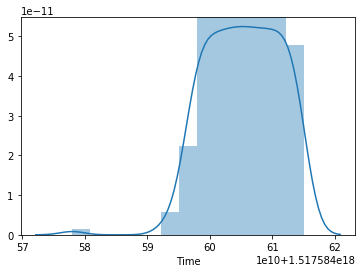

In [55]:
sns.distplot(df['Time'])

In [56]:
df

,Time,Source,Destination,Protocol,Type,Size
Time,,,,,,
2018-02-02 15:16:18,2018-02-02 15:16:18,0.0.0.0,255.255.255.255,UDP,outgoing,390
2018-02-02 15:16:33,2018-02-02 15:16:33,0.0.0.0,255.255.255.255,UDP,incoming,344
2018-02-02 15:16:33,2018-02-02 15:16:33,0.0.0.0,255.255.255.255,UDP,outgoing,344
2018-02-02 15:16:35,2018-02-02 15:16:35,0.0.0.0,255.255.255.255,UDP,incoming,344
2018-02-02 15:16:35,2018-02-02 15:16:35,0.0.0.0,255.255.255.255,UDP,outgoing,344
2018-02-02 15:16:36,2018-02-02 15:16:36,192.168.12.1,192.168.12.199,ICMP,outgoing,48
2018-02-02 15:16:36,2018-02-02 15:16:36,192.168.12.1,192.168.12.199,UDP,outgoing,328
2018-02-02 15:16:36,2018-02-02 15:16:36,192.168.12.1,192.168.12.199,UDP,outgoing,328
2018-02-02 15:16:36,2018-02-02 15:16:36,0.0.0.0,255.255.255.255,UDP,incoming,356
